In [2]:
import argparse
import cv2
from cv2 import GaussianBlur
from data import AvirisDataset
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle
import rasterio
import torch
from model import TwoBranchCNN
from tqdm import tqdm
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

In [ ]:
# with open('selected_for_training.pkl','rb') as f:
#         selected = pickle.load(f)
#         test_image_ids = [i for i in range(4) if i not in selected]
# selected, test_image_ids

([1, 0], [2, 3])

In [71]:
with open('hist_loss.json','r') as file:
    hist_loss = json.load(file)

In [72]:
hist_train_loss = hist_loss['hist_loss']
hist_val_loss = hist_loss['hist_val_loss']

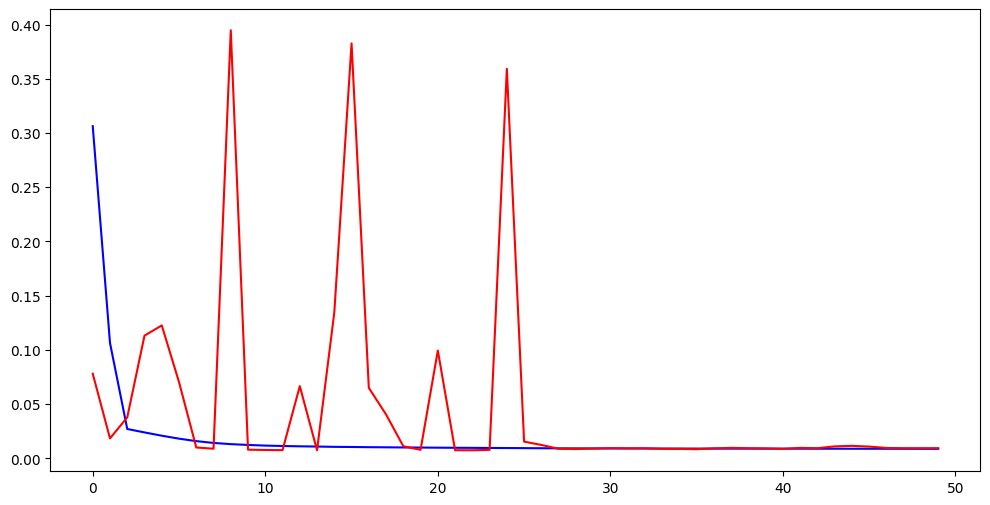

In [73]:
plt.figure(figsize=(12,6))
plt.plot(range(len(hist_train_loss)),hist_train_loss, c='b')
plt.plot(range(len(hist_val_loss)),hist_val_loss, c='r')


In [6]:
def load_checkpoint(model, optimizer=None, scheduler=None, path=None, device='cpu'):
    """
    Loads model, optimizer, and scheduler states from a checkpoint file.

    Parameters:
        model (torch.nn.Module): Model instance to load weights into.
        optimizer (torch.optim.Optimizer, optional): Optimizer instance.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler instance.
        path (str): Path to the checkpoint file.
        device (str or torch.device): Device to map the checkpoint to.

    Returns:
        model (torch.nn.Module): Model with loaded weights.
        optimizer (torch.optim.Optimizer, optional): Optimizer with loaded state (if provided).
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler with loaded state (if provided).
        start_epoch (int): Epoch to resume training from.
    """
    if path is None:
        raise ValueError("Checkpoint path must be provided.")

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'], strict=False)
    
    start_epoch = checkpoint.get('epoch', 0) + 1

    if optimizer and 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])

    if scheduler and 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])

    print(f"Loaded checkpoint from {path}, resuming at epoch {start_epoch}")
    return model, optimizer, scheduler, start_epoch

In [74]:
# Load trained model

TBCNN = TwoBranchCNN()
model_path = os.path.join('runs','best_epoch023.pt')
print(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TBCNN, _, _, _ = load_checkpoint(TBCNN, path=model_path, device=device )
TBCNN.eval()


size of input layer of FC 2320
runs/best_epoch023.pt
Loaded checkpoint from runs/best_epoch023.pt, resuming at epoch 24


TwoBranchCNN(
  (hsi_branch): Sequential(
    (0): Conv1d(1, 20, kernel_size=(45,), stride=(1,), padding=valid)
    (1): ReLU()
    (2): Conv1d(20, 20, kernel_size=(45,), stride=(1,), padding=valid)
    (3): ReLU()
    (4): Conv1d(20, 20, kernel_size=(45,), stride=(1,), padding=valid)
    (5): ReLU()
  )
  (msi_branch): Sequential(
    (0): Conv2d(4, 30, kernel_size=(10, 10), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(10, 10), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): Conv2d(30, 30, kernel_size=(10, 10), stride=(1, 1), padding=valid)
    (5): ReLU()
  )
  (hsi_flatten): Flatten(start_dim=1, end_dim=-1)
  (msi_flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=2320, out_features=450, bias=True)
    (2): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Line

In [75]:
@torch.no_grad()
def predict(model, patch, spectrum, device):
    transposed_patch = np.transpose(patch,(2,0,1))
    tensor_patch = torch.tensor(transposed_patch).to(device, dtype=torch.float)
    tensor_spectrum = torch.tensor(np.reshape(spectrum,(1,len(spectrum)))).to(device, dtype=torch.float)
    model.cuda()
    pred = model(tensor_spectrum.unsqueeze(0), tensor_patch.unsqueeze(0))
    torch.cuda.empty_cache()
    return pred.detach().cpu().numpy()

In [76]:
def upscale_hyperspectral(img: np.ndarray, target_dims: tuple, method: str = 'bicubic') -> np.ndarray:
    
    assert img.ndim == 3, "Input image must have shape (bands, height, width)"
    assert method in ['bilinear', 'bicubic'], "Method must be 'bilinear' or 'bicubic'"
    
    interp = cv2.INTER_LINEAR if method == 'bilinear' else cv2.INTER_CUBIC
    _, _, bands = img.shape
    H, W = target_dims
    upscaled = np.zeros((H, W, bands), dtype=img.dtype)
    
    for b in range(bands):
        upscaled[:,:,b] = cv2.resize(img[:,:,b], (W,H), interpolation=interp)
    
    return upscaled

In [ ]:
# Fonction qui calcule l'image prédite : prendre en entrée MSI/HSI, upscaler HSI, boucler sur i et j, appeler le modèle, prédire le spectre, remplir le cube de sortie
def build_image(model: torch.nn, hsi: np.array, msi: np.array, scale: int, device: torch.cuda.device) -> np.array:
    """ 
    msi : H,W,c
    hsi: h,w,C
    """
    H, W = msi.shape[:2]
    C = hsi.shape[2]
    hrhsi = np.zeros((H,W,C))
    upscaled_hsi = upscale_hyperspectral(hsi,(H,W), method='bicubic')
    offset = int((model.patch_size - 1)/2)
    for i in tqdm(range(offset, H - offset)):
        for j in range(offset, W - offset):
            current_patch_msi = msi[i-offset:i+offset+1,j-offset:j+offset+1,:] # Problème : quid du cas où le patch contient des pixels non valides ?
            current_spectrum_hsi = upscaled_hsi[i,j,:]
            hrhsi[i,j,:] = predict(model, current_patch_msi,current_spectrum_hsi,device)
    return hrhsi 

### FITS Images

In [58]:
from astropy.io import fits

hdu_list = fits.open("/mnt/c/data/AVIRIS/GT/ang20160910t223011_rdn_v1n2_vnir_gt.fits")
hdu_list.info()
hdu_list.close()
image_data = fits.getdata("/mnt/c/data/AVIRIS/GT/ang20160910t223011_rdn_v1n2_vnir_gt.fits")

Filename: /mnt/c/data/AVIRIS/GT/ang20160910t223011_rdn_v1n2_vnir_gt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (287, 513, 66)   float32   


In [59]:
type(image_data)

numpy.ndarray

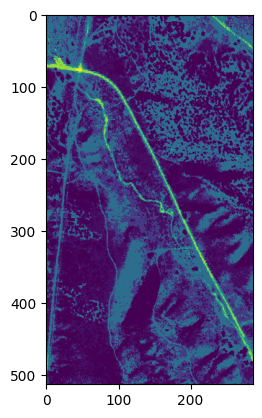

In [61]:
plt.imshow(image_data[0,:,:])

#### Get dataset for tests

In [78]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [81]:
args = SimpleNamespace(
    image_path='/mnt/c/data/AVIRIS/',
    srf_path="srf/Landsat8_BGRI_SRF.xls",
    image_number=4,
    seed=3407,
    patch_size=31,
    scale=2,
    train_mode=False,
    training_ratio=0.7,
    stride=31
)

In [82]:
# Use Aviris Dataset class and tools
set_seed(args.seed)
dataset = AvirisDataset(args=args, device=device)

Low resolution 15
4
Number of tiles 4
Making test dataset
Reading HS data from /mnt/c/data/AVIRIS/f111116t01p00r21/f111116t01p00r21rdn_c/f111116t01p00r21rdn_c_sc01_ort_img
Shape of hyperspectral data: (224, 2955, 1067)
Number of bands: 224
Test dataset built


In [15]:
torch.cuda.empty_cache()

In [83]:
test_hrhsi = dataset.test_GT_list[0]
test_hrmsi = dataset.test_HRMSI_list[0]
test_lrhsi = dataset.test_LRHSI_list[0]
print(len(dataset.test_GT_list))

1


In [84]:
print(test_hrhsi.shape)
print(test_lrhsi.shape)
print(test_hrmsi.shape)

(2955, 1067, 224)
(1477, 533, 224)
(2955, 1067, 4)


In [85]:
dataset.image_list

['/mnt/c/data/AVIRIS/f111116t01p00r19/f111116t01p00r19rdn_c/f111116t01p00r19rdn_c_sc01_ort_img.hdr',
 '/mnt/c/data/AVIRIS/f111116t01p00r20/f111116t01p00r20rdn_c/f111116t01p00r20rdn_c_sc01_ort_img.hdr',
 '/mnt/c/data/AVIRIS/f111116t01p00r21/f111116t01p00r21rdn_c/f111116t01p00r21rdn_c_sc01_ort_img.hdr',
 '/mnt/c/data/AVIRIS/f111116t01p00r22/f111116t01p00r22rdn_c/f111116t01p00r22rdn_c_sc01_ort_img.hdr']

In [86]:
dataset.image_list
with rasterio.open(dataset.image_list[2][:-4]) as src:
    test = src.read()

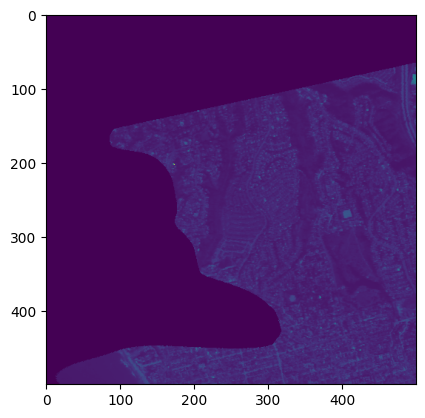

In [87]:
plt.imshow(test[15,:500,:500])

In [69]:
(test[15,:500,:500] ==-50).any(where=True)
toto = (test[15,:500,:500] == -50).astype(int)

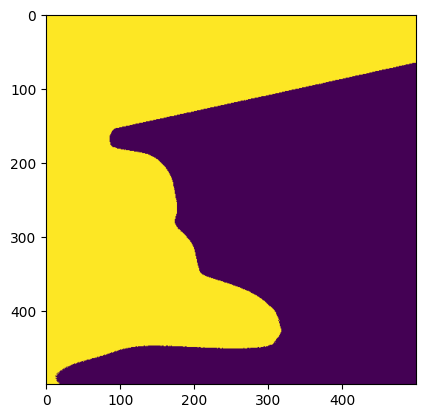

In [70]:
plt.imshow(toto)

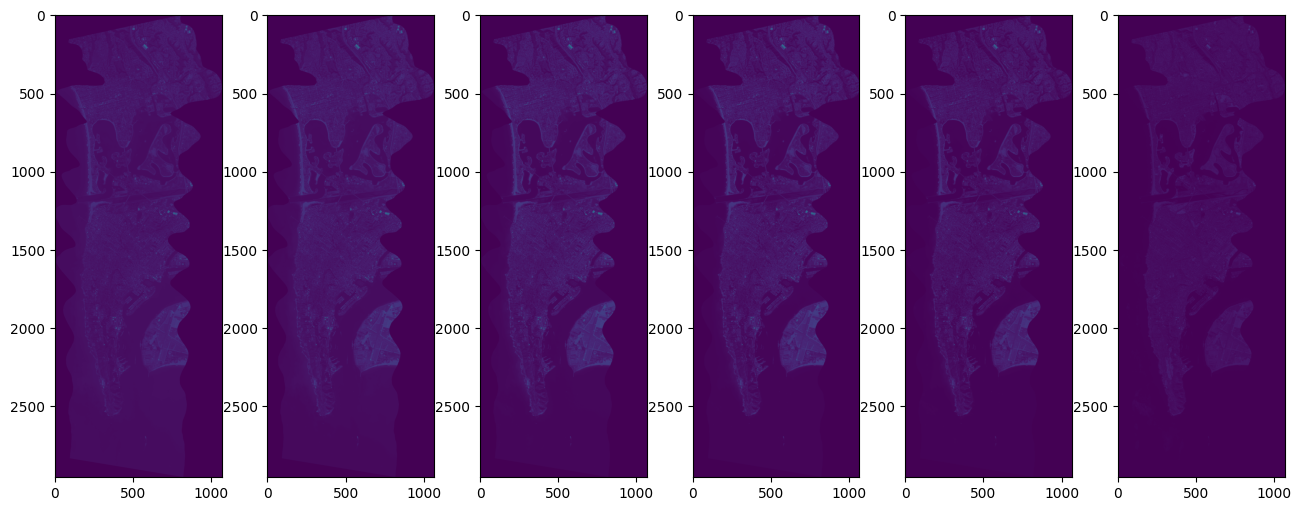

In [88]:
fig, ax = plt.subplots(1,6)
fig.set_size_inches((16,6))
start = 160
step = 5
init = 10
for i in range(1,7):
    curr = start + i
    plt.subplot(start+i)
    plt.imshow(test_hrhsi[:,:,init+step*i])

In [89]:
test_hrhsi[:,:,:].sum().item() != 0

True

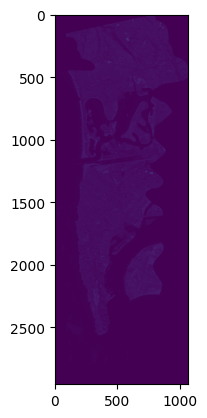

In [90]:
plt.imshow(test_hrhsi[:,:,10+step*i])

In [36]:
pred_hrhsi = build_image(TBCNN,test_lrhsi,test_hrmsi,2,device)

100%|██████████| 2925/2925 [1:12:37<00:00,  1.49s/it]


In [37]:
pred_hrhsi.shape
(2799, 1076, 224)

(2799, 1076, 224)

In [36]:
from utils import Metric

test_metric = Metric()

In [35]:
with open("pred_hrhsi.pkl", "wb") as f:
    pickle.dump(pred_hrhsi, f)

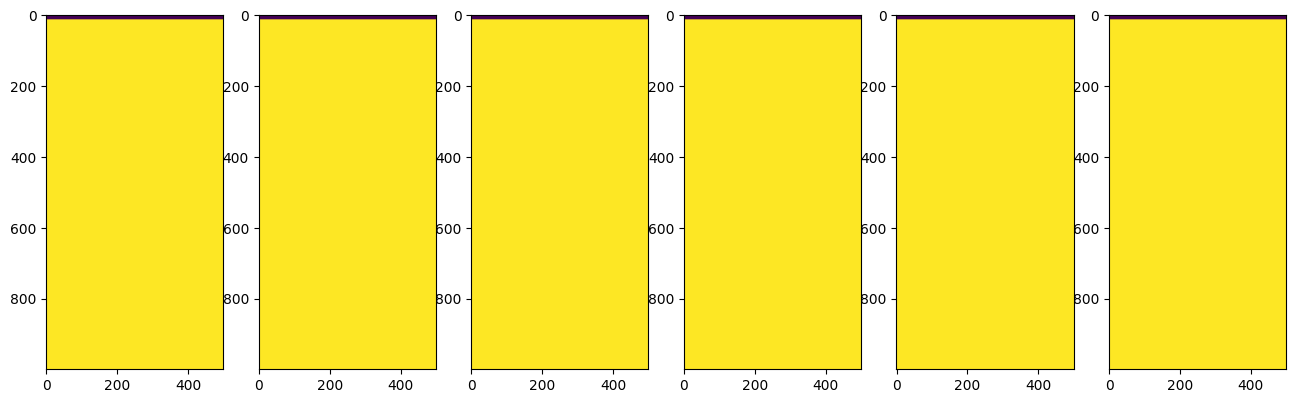

In [38]:
fig, ax = plt.subplots(1,6)
fig.set_size_inches((16,6))
start = 160
step = 5
for i in range(1,7):
    curr = start + i
    plt.subplot(start+i)
    plt.imshow(pred_hrhsi[:1000,500:1000,10+step*i])

### Crop maximum valid rectangle from images

In [97]:
with rasterio.open('/mnt/c/data/AVIRIS/f111116t01p00r19/f111116t01p00r19rdn_c/f111116t01p00r19rdn_c_sc01_ort_img') as src:
    hyperspectral_data = src.read()

In [99]:
hyperspectral_data = rearrange(hyperspectral_data,'c h w -> h w c')

In [ ]:
hyperspectral_data.shape

(2799, 1076, 224)

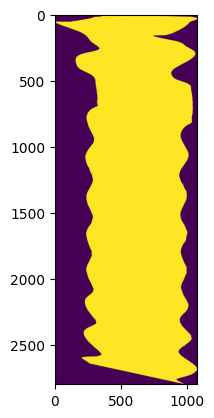

In [103]:
mask = np.all(hyperspectral_data != -50, axis=2).astype(np.uint8)
plt.imshow(mask)

In [104]:
def get_max_inner_rectangle(hsi_image: np.ndarray, invalid_value: float = -50):
    """
    Extract the largest inner rectangle with no unobserved pixels from a hyperspectral image.
    
    Args:
        hsi_image (np.ndarray): Hyperspectral image (H, W, C)
        invalid_value (float): Value indicating unobserved pixels
        
    Returns:
        tuple: (x, y, w, h) of the largest valid rectangle
    """
    # Use the first band to detect unobserved pixels (or min across bands)
    mask = np.all(hsi_image != invalid_value, axis=2).astype(np.uint8)
    
    # Convert binary mask to a form suitable for the algorithm
    height, width = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)
    hist = np.zeros(width, dtype=int)

    for i in range(height):
        for j in range(width):
            hist[j] = hist[j] + 1 if mask[i, j] == 1 else 0
        # Use histogram to find largest rectangle in this row
        stack = []
        j = 0
        while j <= width:
            h = hist[j] if j < width else 0
            if not stack or h >= hist[stack[-1]]:
                stack.append(j)
                j += 1
            else:
                top = stack.pop()
                w = j if not stack else j - stack[-1] - 1
                area = hist[top] * w
                if area > max_area:
                    max_area = area
                    x = stack[-1] + 1 if stack else 0
                    y = i - hist[top] + 1
                    max_rect = (x, y, w, hist[top])
    return max_rect


In [106]:
x, y, w, h = get_max_inner_rectangle(hyperspectral_data,-50)

In [107]:
cropped_hsi = hyperspectral_data[y:y+h, x:x+w, :]

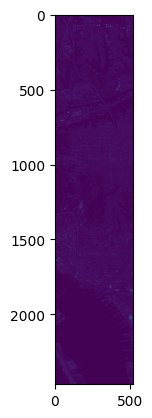

In [108]:
plt.imshow(cropped_hsi[:,:,10])

In [109]:
np.min(cropped_hsi[:,:,10])

np.int16(895)

In [ ]:
np.max(cropped_hsi[:,:,10])

np.int16(27043)